In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Verificar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [2]:
# Autoencoder para reducir la dimensionalidad de las imágenes
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(170 * 170, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32)  # La representación reducida será de 32 dimensiones
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 170 * 170),
            nn.Sigmoid()  # Las imágenes son normalizadas a valores entre 0 y 1
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Cargar y preprocesar las imágenes
def load_images(ruta_muestras):
    imagenes = []
    archivos = os.listdir(ruta_muestras)
    for archivo in tqdm(archivos, desc='Cargando imágenes'):
        ruta_imagen = os.path.join(ruta_muestras, archivo)
        try:
            imagen = imread(ruta_imagen, as_gray=True)
            imagen = resize(imagen, (170, 170)).flatten()  # Convertir la imagen en un vector 1D
            imagenes.append(imagen)
        except Exception as e:
            print(f'Error al procesar {archivo}: {e}')
    return np.array(imagenes)

In [3]:
# Ruta de las imágenes
ruta_muestras = r'D:\Python\TESIS\MUESTRAS_CENTRADAS_V2\MUESTRAS_C1_1900MHZ'
imagenes = load_images(ruta_muestras)

Cargando imágenes: 100%|████████████████████████████████████████████████████████████| 886/886 [00:03<00:00, 250.15it/s]


In [4]:
# Convertir las imágenes a tensores de PyTorch y crear DataLoader
imagenes_tensor = torch.tensor(imagenes, dtype=torch.float32)
dataset = TensorDataset(imagenes_tensor)
batch_size = 64  # Tamaño del batch (puedes ajustarlo según el uso de memoria)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
# Inicializar el Autoencoder y moverlo a la GPU
autoencoder = Autoencoder().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [6]:
# Entrenar el Autoencoder
n_epochs = 50
for epoch in range(n_epochs):
    autoencoder.train()
    epoch_loss = 0.0
    for batch in dataloader:
        batch = batch[0].to(device)  # Mover el batch a la GPU
        optimizer.zero_grad()
        encoded, decoded = autoencoder(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")


Epoch [1/50], Loss: 0.0671
Epoch [2/50], Loss: 0.0174
Epoch [3/50], Loss: 0.0129
Epoch [4/50], Loss: 0.0078
Epoch [5/50], Loss: 0.0071
Epoch [6/50], Loss: 0.0068
Epoch [7/50], Loss: 0.0067
Epoch [8/50], Loss: 0.0065
Epoch [9/50], Loss: 0.0067
Epoch [10/50], Loss: 0.0064
Epoch [11/50], Loss: 0.0061
Epoch [12/50], Loss: 0.0059
Epoch [13/50], Loss: 0.0054
Epoch [14/50], Loss: 0.0051
Epoch [15/50], Loss: 0.0049
Epoch [16/50], Loss: 0.0046
Epoch [17/50], Loss: 0.0044
Epoch [18/50], Loss: 0.0041
Epoch [19/50], Loss: 0.0040
Epoch [20/50], Loss: 0.0038
Epoch [21/50], Loss: 0.0037
Epoch [22/50], Loss: 0.0036
Epoch [23/50], Loss: 0.0037
Epoch [24/50], Loss: 0.0036
Epoch [25/50], Loss: 0.0035
Epoch [26/50], Loss: 0.0036
Epoch [27/50], Loss: 0.0035
Epoch [28/50], Loss: 0.0035
Epoch [29/50], Loss: 0.0036
Epoch [30/50], Loss: 0.0033
Epoch [31/50], Loss: 0.0030
Epoch [32/50], Loss: 0.0029
Epoch [33/50], Loss: 0.0029
Epoch [34/50], Loss: 0.0028
Epoch [35/50], Loss: 0.0028
Epoch [36/50], Loss: 0.0030
E

In [7]:
# Obtener las representaciones reducidas de las imágenes en mini-batches
autoencoder.eval()
encoded_images = []

with torch.no_grad():
    for batch in dataloader:
        batch = batch[0].to(device)
        encoded, _ = autoencoder(batch)
        encoded_images.append(encoded.cpu().numpy())  # Mover las representaciones a la CPU

# Convertir las representaciones reducidas a NumPy para usar KMeans
encoded_images_np = np.vstack(encoded_images)

Calculando inercia y coeficiente de silueta:   0%|                                               | 0/8 [00:00<?, ?it/s]C:\ProgramData\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Calculando inercia y coeficiente de silueta:  12%|████▉                                  | 1/8 [00:00<00:02,  2.96it/s]C:\ProgramData\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Calculando inercia y coeficiente de silueta:  25%|█████████▊                             | 2/8 [00:00<00:01,  4.77it/s]C:\ProgramData\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluste

dmax: 2.15 en k = 4


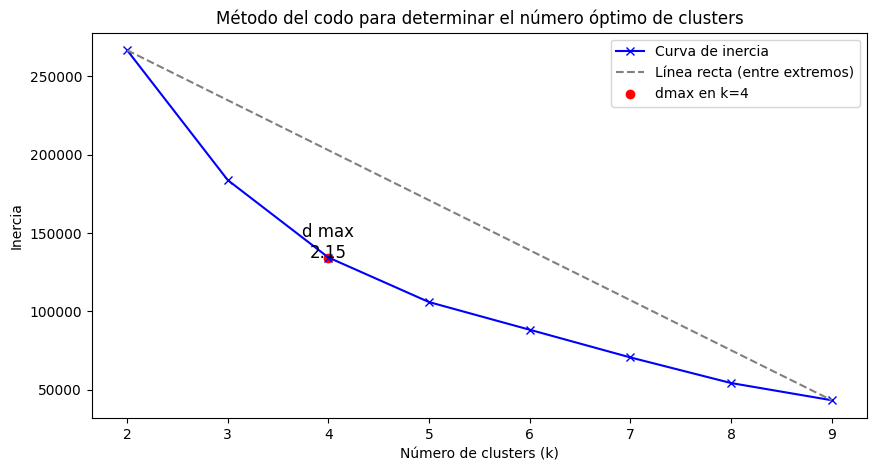

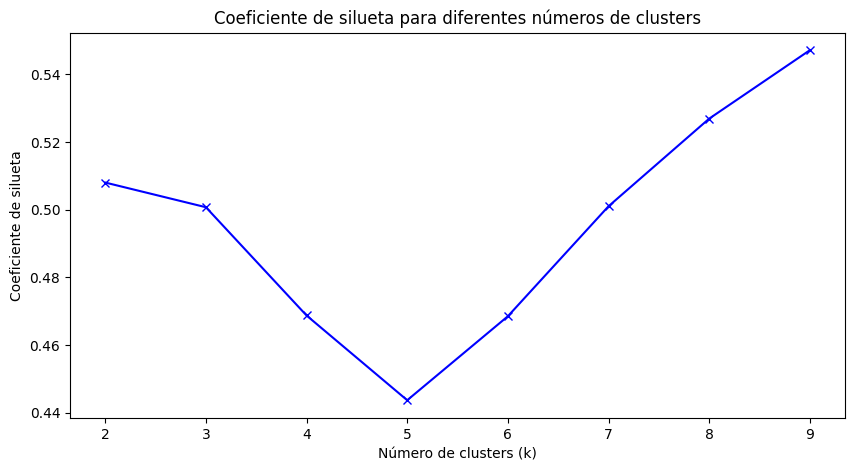

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

# Datos de ejemplo (puedes reemplazar 'encoded_images_np' por tus propios datos)
# Método del codo y coeficiente de silueta usando KMeans
range_n_clusters = range(2, 10)
inertia = []
silhouette_avg = []

for n_clusters in tqdm(range_n_clusters, desc='Calculando inercia y coeficiente de silueta'):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(encoded_images_np)  # Asegúrate de definir tus datos
    inertia.append(kmeans.inertia_)
    
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(encoded_images_np, cluster_labels))

# Convertir a arrays para facilidad de cálculo
inertia_values = np.array(inertia)
k_values = np.array(range_n_clusters)

# Definir los puntos extremos (primer y último punto)
p1 = np.array([k_values[0], inertia_values[0]])  # Primer punto
p2 = np.array([k_values[-1], inertia_values[-1]])  # Último punto

# Calcular la distancia entre cada punto de la curva y la línea recta que conecta p1 y p2
def calcular_distancia(p1, p2, p3):
    # p1 y p2 son los puntos extremos, p3 es el punto de la curva
    return np.abs(np.cross(p2-p1, p3-p1) / np.linalg.norm(p2-p1))

distancias = []
for i in range(len(k_values)):
    p3 = np.array([k_values[i], inertia_values[i]])
    dist = calcular_distancia(p1, p2, p3)
    distancias.append(dist)

# Encontrar el valor de dmax y su posición
dmax = np.max(distancias)
pos_dmax = np.argmax(distancias)

print(f"dmax: {dmax:.2f} en k = {k_values[pos_dmax]}")

# Graficar el método del codo con la línea y dmax
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_values, 'bx-', label='Curva de inercia')
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'gray', linestyle='--', label='Línea recta (entre extremos)')

# Resaltar el punto de dmax
plt.scatter(k_values[pos_dmax], inertia_values[pos_dmax], color='red', label=f'dmax en k={k_values[pos_dmax]}')

# Añadir texto de dmax
plt.text(k_values[pos_dmax], inertia_values[pos_dmax], f'd max\n{dmax:.2f}', fontsize=12, color='black', ha='center')

# Etiquetas y título
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del codo para determinar el número óptimo de clusters')
plt.legend()
plt.show()

# Gráfico del coeficiente de silueta
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_avg, 'bx-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Coeficiente de silueta')
plt.title('Coeficiente de silueta para diferentes números de clusters')
plt.show()


C:\ProgramData\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para 2 clusters, el promedio del coeficiente de silueta es 0.51


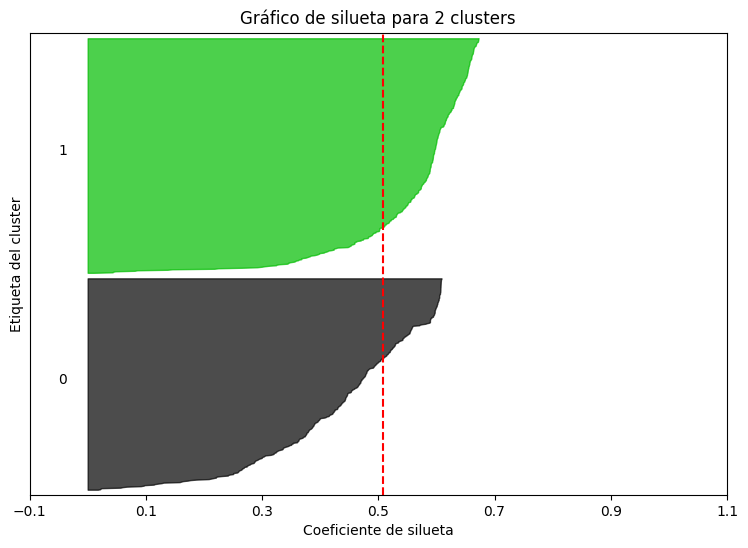

C:\ProgramData\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para 3 clusters, el promedio del coeficiente de silueta es 0.50


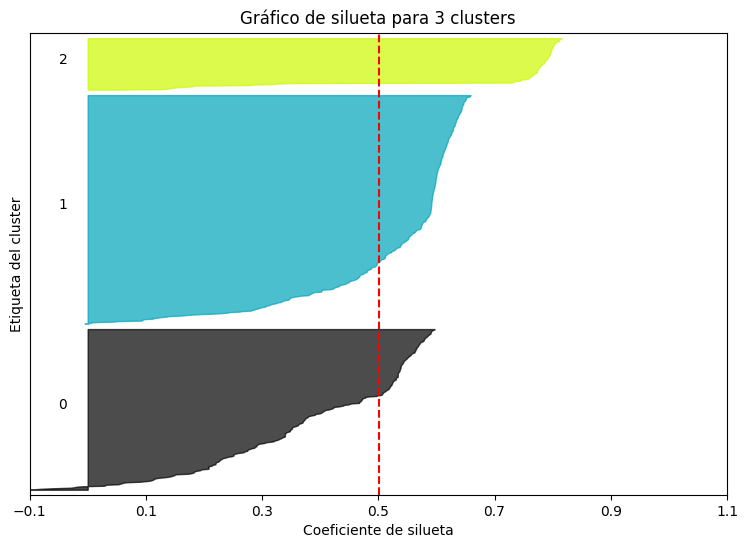

C:\ProgramData\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para 4 clusters, el promedio del coeficiente de silueta es 0.47


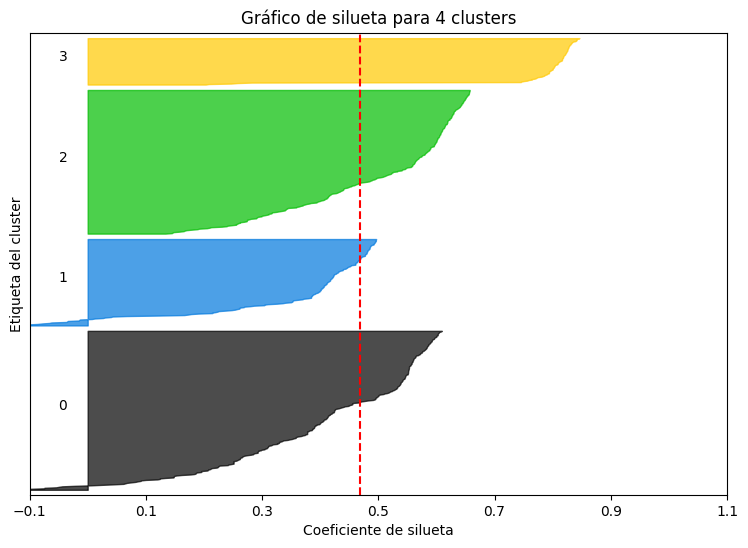

C:\ProgramData\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para 5 clusters, el promedio del coeficiente de silueta es 0.44


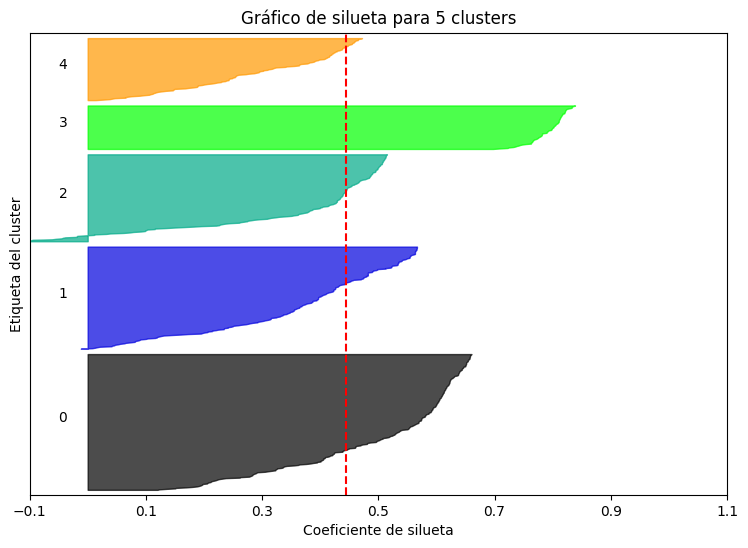

C:\ProgramData\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para 6 clusters, el promedio del coeficiente de silueta es 0.47


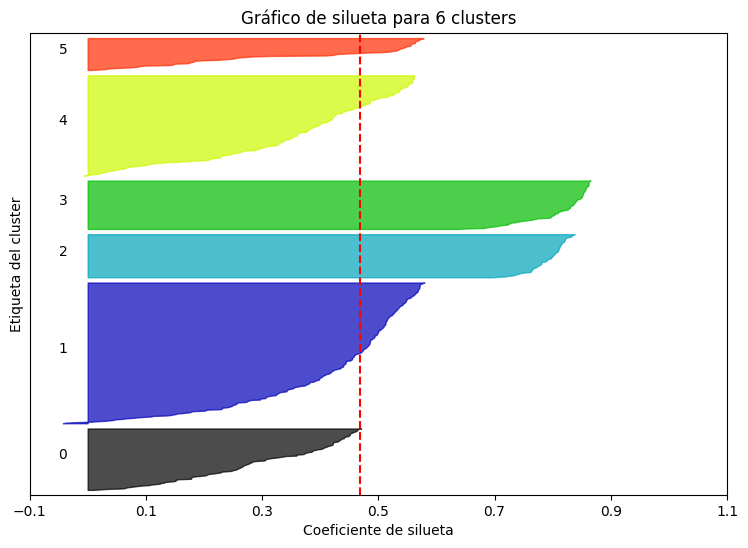

C:\ProgramData\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para 7 clusters, el promedio del coeficiente de silueta es 0.50


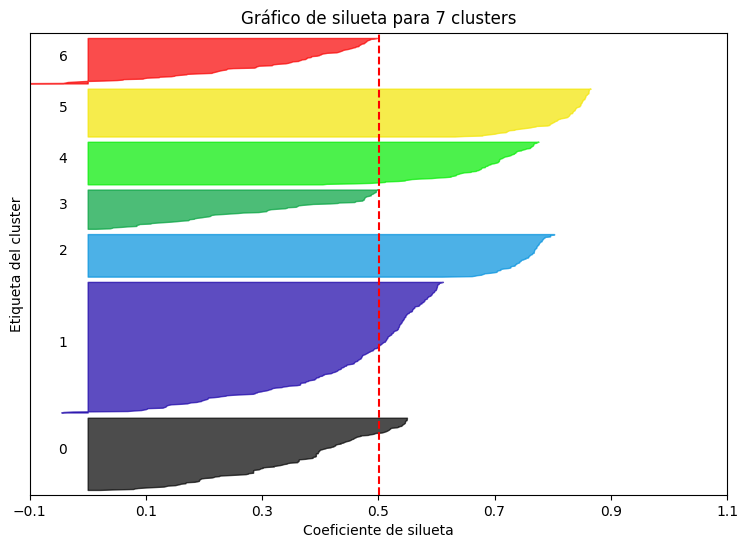

C:\ProgramData\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para 8 clusters, el promedio del coeficiente de silueta es 0.53


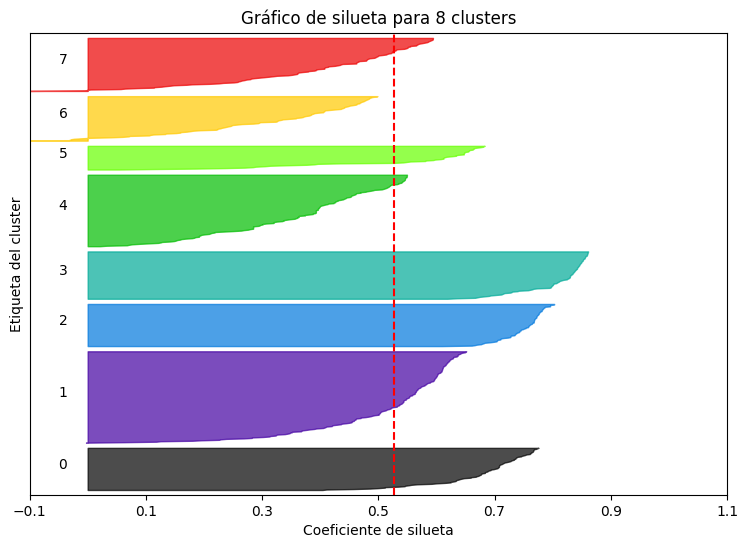

C:\ProgramData\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para 9 clusters, el promedio del coeficiente de silueta es 0.55


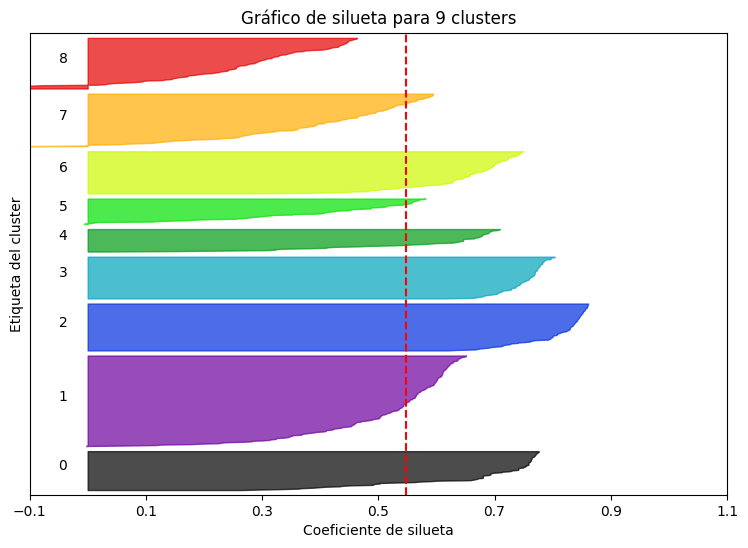

In [9]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# Asegúrate de que X esté definido como las representaciones reducidas o los datos
# Asumiendo que estás utilizando las representaciones codificadas del autoencoder
# Definir X como los datos codificados (representaciones reducidas)
X = encoded_images_np  # Usa las representaciones reducidas del autoencoder o tus datos originales

def plot_silhouette(X, range_n_clusters):
    for n_clusters in range_n_clusters:
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(9, 6)

        # El gráfico de silueta puede tener valores negativos (cuando los puntos están mal asignados)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Aplicar K-Means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(X)

        # Calcular el promedio del coeficiente de silueta para el número de clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(f'Para {n_clusters} clusters, el promedio del coeficiente de silueta es {silhouette_avg:.2f}')

        # Calcular los valores de silueta para cada muestra
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

            # Etiquetar el cluster
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Calcular la nueva posición de y_lower
            y_lower = y_upper + 10  # Espacio entre clusters

        ax1.set_title(f'Gráfico de silueta para {n_clusters} clusters')
        ax1.set_xlabel('Coeficiente de silueta')
        ax1.set_ylabel('Etiqueta del cluster')

        # Dibujar la línea vertical para el promedio del coeficiente de silueta
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Eliminar etiquetas en el eje Y
        ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

        plt.show()

# Ahora llamas a la función con el rango de clusters que deseas evaluar
range_n_clusters = range(2, 10)  # Ajusta el rango según tu necesidad
plot_silhouette(X, range_n_clusters)
